In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Read in the dataset
words = open('/content/drive/MyDrive/ML Learning/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
len(words)

32033

In [ ]:
# Building the vocab encoding and decoding
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
# Building the dataset

block_size = 5 # The number of characters we are using to predict the next character

def build_dataset(words):
  X, Y = [],[]
  for w in words:
    context = [0]*block_size
    for ch in w +'.':
      ix = stoi[ch]
      X.append(context) # X is the context
      Y.append(ix) # Y is the current char
      #print(''.join(itos[i] for i in context), '---->', itos[ix]) # Visualising what we are doing
      context = context[1:] + [ix] # Roll the context along 1

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

# Splitting into train, dev, test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtes, Ytes = build_dataset(words[n2:])

In [ ]:
# The network: input layer ---> into a hidden layer ---> into an output layer

In [ ]:
# Hyper parameters for playing with (omitting block size)

mini_batch_size = 500
enc_sze = 5 # The size of the encoding for characters
layer_size = 300 # The hidden layer size
training_steps = 50000 # Number of training iterations
lr = 0.1 # Learning rate

# Variables for tracking and plotting
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [ ]:
# Parameters of the model
g = torch.Generator().manual_seed(2147836473)
C = torch.rand((27,enc_sze)) # embeddings table for letters making them the encoding size(instead of 27 for OHE)
w1 = torch.rand((enc_sze*block_size, layer_size)) # weigths between input layer and hidden layer
b1 = torch.rand(layer_size) # bias for the hidden layer
w2 = torch.rand((layer_size, 27)) # weights between hidden layer and output layer
b2 = torch.rand(27) # bias for output layer
parameters = [C, w1, b1, w2, b2]
# Looking at number of parameters
print(sum(p.nelement() for p in parameters))

# Make sure the parameters require grad
for p in parameters:
  p.requires_grad = True

16062


In [ ]:
for i in range(training_steps):

  # Creating mini batches randomly
  ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

  # Forward Pass
  emb = C[Xtr[ix]] # Embedding the letters for a minibatch. (32, 3, 2)
  h = torch.tanh(emb.view(-1, enc_sze*block_size) @ w1 + b1) # Hidden layer operation. Revise broadcasting and check on the plus operation (32, hidden layer size)
  logits = h @ w2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) # This is dong the same as the below lines of code but better! (simpler, numerically better (big values and e))
  # counts = logits.exp() # Fake counts
  # prob = counts / counts.sum(1, keepdims=True) # Convert to prob dist.
  # loss = -prob[torch.arange(32), Y].log().mean() # Calculate neg log loss for the Ys.

  # Backward pass
  for p in parameters: # Dont forget to reset the gradients to 0
    p.grad = None
  loss.backward()

  # Update
  for p in parameters:
    if i <= 45000:
      p.data += -lr * p.grad
    else:
      p.data += -0.01 * p.grad

  # Track stats
  #lri.append(lrs[i])
  lossi.append(loss.log10().item())
  stepi.append(i)

#print(loss.item())

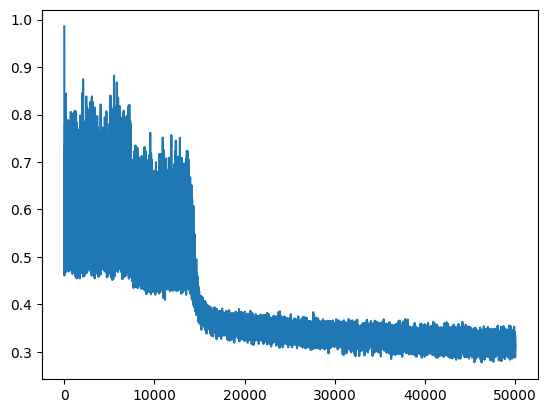

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# Evaluating Loss for training
emb = C[Xtr] # Embedding the letters for X. (32, 3, 2)
h = torch.tanh(emb.view(-1, enc_sze*block_size) @ w1 + b1) # First layer. Research .view. Revise broadcasting and check on the plus operation (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0790, grad_fn=<NllLossBackward0>)

In [ ]:
# Evaluating Loss on dev to tune hperparameters
emb = C[Xdev] # Embedding the letters for X. (32, 3, 2)
h = torch.tanh(emb.view(-1, enc_sze*block_size) @ w1 + b1) # First layer. Research .view. Revise broadcasting and check on the plus operation (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1268, grad_fn=<NllLossBackward0>)

In [ ]:
# Evaluating Loss on dev to tune hperparameters
emb = C[Xtes] # Embedding the letters for X. (32, 3, 2)
h = torch.tanh(emb.view(-1, enc_sze*block_size) @ w1 + b1) # First layer. Research .view. Revise broadcasting and check on the plus operation (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytes)
loss

tensor(2.1154, grad_fn=<NllLossBackward0>)

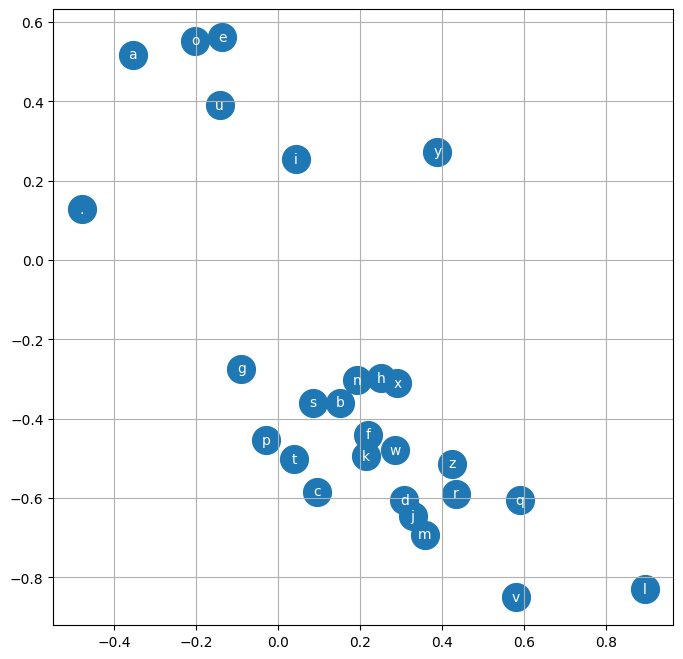

In [ ]:
# Visulaising the 2d letter embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=400)
for i in range(C.shape[0]):
  plt.text(C[i,0].data, C[i,1].data, s=itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# Name generation

g = torch.Generator().manual_seed(42)

for _ in range(10):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ w1 + b1)
    logits = h @ w2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

yevsy.
haviah.
nolan.
khalei.
nyani.
yahdan.
eliena.
dayanni.
eryshel.
shad.
